# MultiFit atmospheric parameters with covariance matrix - No Filter date 2022/12/07 PSF2DFFM REBIN2

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : April 24th 2023
- last update : April 24th 2023

- Multi fit means pwv may be fitted in several bands independently

# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle
import h5py
import seaborn as sns
import copy
from collections import OrderedDict

In [2]:
sys.path.append('./lib')
from libAtmosphericFit import *

libAtmosphericFit.py :: Use atmosphtransmemullsst.__path__[0],'../data/simplegrid as the path to data
libAtmosphericFit.py :: data_path = /Users/sylvie/mambaforge/lib/python3.10/site-packages/atmosphtransmemullsst/../data/simplegrid
SimpleAtmEmulator:path=/Users/sylvie/mambaforge/lib/python3.10/site-packages/atmosphtransmemullsst/../data/simplegrid


In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits',
 'thermtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [6]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [7]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import RegularGridInterpolator

In [8]:
# import libradtran
sys.path.append('../../../simulation/atmsim/libradtran')
import libsimulateVisible

libradtranpath= /Users/sylvie/MacOSX/External/libRadtran2/


In [9]:
#from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

In [10]:
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

class Line:
    """Class modeling the emission or absorption lines."""

    def __init__(self, wavelength, label, atmospheric=False, emission=False, label_pos=[0.007, 0.02],
                 width_bounds=[0.5, 6], use_for_calibration=False):
        """Class modeling the emission or absorption lines. lines attributes contains main spectral lines
        sorted in wavelength.

        Parameters
        ----------
        wavelength: float
            Wavelength of the spectral line in nm
        label: str

        atmospheric: bool
            Set True if the spectral line is atmospheric (default: False)
        emission: bool
            Set True if the spectral line has to be detected in emission. Can't be true if the line is atmospheric.
            (default: False)
        label_pos: [float, float]
            Position of the label in the plot with respect to the vertical lin (default: [0.007,0.02])
        width_bounds: [float, float]
            Minimum and maximum width (in nm) of the line for fitting procedures (default: [1,7])
        use_for_calibration: bool
            Use this line for the dispersion relation calibration, bright line recommended (default: False)

        Examples
        --------
        >>> l = Line(550, label='test', atmospheric=True, emission=True)
        >>> print(l.wavelength)
        550
        >>> print(l.label)
        test
        >>> print(l.atmospheric)
        True
        >>> print(l.emission)
        False
        """
        self.wavelength = wavelength  # in nm
        self.label = label
        self.label_pos = label_pos
        self.atmospheric = atmospheric
        self.emission = emission
        if self.atmospheric:
            self.emission = False
        self.width_bounds = width_bounds
        self.fitted = False
        self.use_for_calibration = use_for_calibration
        self.high_snr = False
        self.fit_lambdas = None
        self.fit_gauss = None
        self.fit_bgd = None
        self.fit_snr = None
        self.fit_fwhm = None
        self.fit_popt = None
        self.fit_pcov = None
        self.fit_popt_gaussian = None
        self.fit_pcov_gaussian = None
        self.fit_chisq = None
        self.fit_eqwidth_mod = None
        self.fit_eqwidth_data = None
        #self.fit_bgd_npar = parameters.CALIB_BGD_NPARAMS
        self.fit_bgd_npar = None


In [11]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

#my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
#hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
#hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
#oxygen_lines_order1 = Lines([O2_1,O2_2])

In [12]:
#ax.plot([x_O2_1,x_O2_1],[72,100],'b-',lw=3)
#ax.annotate(O2_1.label, xy=(x_O2_1, 80), color='b',fontsize=20,fontweight='bold')

In [13]:
os.getenv("PYSYN_CDBS")

'/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds'

In [14]:
path_calspec = os.path.join(os.getenv("PYSYN_CDBS"),"calspec")
   

dict_sedfilename = {'HD38666': "mucol_stis_005.fits", 
            'HD185975': "hd185975_stis_003.fits",
            'HD074000': "hd074000_stis_003.fits",
            'HD60753' : "hd60753_stis_003.fits",
            'HD111980': "hd111980_stis_003.fits",
            'HD37962':  "hd37962_stis_005.fits",
            'HD031128' : "hd031128_stis_005.fits",
            'HD14943' : "hd14943_stis_005.fits",
            'HD38949' : "hd38949_stis_005.fits",
            'HD60753' : "hd60753_stis_004.fits",
             'HD200654': "hd200654_stis_006.fits",  
             'HD115169': "hd115169_stis_003.fits",
             'HD142331': "hd142331_stis_004.fits", 
             'HD167060': "hd167060_stis_004.fits", 
              }         

In [15]:
# Must divide the observed flux by this correction area
correction_area = 1.06/1.13

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [16]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [17]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [18]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [19]:
def GetSpectra(dict_spectra,factor=1.):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    #correction_area = 1.06/1.13
    correction_area = 1
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]/ correction_area*factor 
        df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]/ correction_area*factor 
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [20]:
def GetColumnHfData(h5spectra,list_of_keys,nameval):
    """
    Extract h5file atttribute 
    
    parameters
      hf           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
      the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=h5spectra.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data

In [21]:
def reorder(df,all_subgroup_keys):
    
    if 'me_az_rms' in all_subgroup_keys:
        df = df.reindex(columns=['index',
                         'exposure',
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                         "me_az_rms",
                         "me_el_rms",
                         "me_rot_rms",
                         "me_image_az_rms",
                         "me_image_el_rms",
                         "me_image_rot_rms",
                        ])
    else:
        df = df.reindex(columns=['index',
                         'exposure',
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                        ])
        
    return df

In [22]:
def GetSpectraH5(h5spectra,factor=1.):
    """
    GetSpectraH5(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # pick one key    
    key_sel =  sorted_spectra_keys[0]
    # pick one group
    group = h5spectra.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
    #d = h5group.create_dataset("spec_lambdas",data=spec.lambdas,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data",data=spec.data,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err",data=spec.err,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_covmatrix",data=spec.cov_matrix,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data_next_order",data=spec.data_next_order,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err_next_order",data=spec.err_next_order,compression="gzip", compression_opt
    
    idx=0
    for key in sorted_spectra_keys :
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
    return df_info , all_df

In [23]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra,factor = 1.):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    #for key, value in dict_spectra.items():
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area*factor
            df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area*factor
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [24]:
def GetSpectraH5Filtered(h5spectra,list_of_bad_spectra,factor=1.):
    """
    GetSpectraH5Filtered(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # compute the list of filtered spectra
    sorted_selected_spectra_keys = [] 
    for key in sorted_spectra_keys:
        key_num = int(key)
        seq = key_num - (key_num//100000)*100000
        if seq not in list_of_bad_spectra and str(seq) not in list_of_bad_spectra:
            sorted_selected_spectra_keys.append(key)
       
    
    # pick one key    
    key_sel =  sorted_selected_spectra_keys[0]
    # pick one group
    group = h5spectra.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_selected_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
    #d = h5group.create_dataset("spec_lambdas",data=spec.lambdas,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data",data=spec.data,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err",data=spec.err,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_covmatrix",data=spec.cov_matrix,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data_next_order",data=spec.data_next_order,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err_next_order",data=spec.err_next_order,compression="gzip", compression_opt
    
    idx=0
    for key in sorted_selected_spectra_keys:
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
    return df_info , all_df

In [25]:
def FindPairOfExposures(df):
    """
    
    Find pair of exposures at similar airmass, one before culmination, the other one after the exposure
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """
    
    
 
    # the culmination  
    idx_zmin = df["airmass"].idxmin()
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[0:idx_zmin]
    
    # df after culmination
    df2 = df.iloc[idx_zmin+1:-1]
    
    #print(df1)
    
    #print(df2)
    
    # loop on exposure before culmination
    #for irow in range(0,idx_zmin):
        # print(irow,df1.iloc[irow][["number","airmass"]])
        
    dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])
    #print(dist)
    closest_idx = np.argmin(dist, axis=0)
    closest_id = df2.iloc[closest_idx]["number"].to_numpy()
    df_output = pd.DataFrame({"idx1": np.arange(0,idx_zmin), 
                              "idx2": closest_idx+idx_zmin+1,
                              "num1":df1["number"],
                              "num2":closest_id,
                              "z1":df1["airmass"].values,
                              "z2":df2.iloc[closest_idx]["airmass"].to_numpy()})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df2.iloc[closest_idx]["refhour"].to_numpy()- df1["refhour"] 
    return df_output
    

In [26]:
def FindPairOfExposuresFromFirst(df):
    """
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """ 
 

    idx_start = 0
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[:idx_start+1]
    
    # df after culmination
    df2 = df.iloc[idx_start+1:]
    N2=len(df2)
    

    df1_new = df1.copy(deep=True)
    df1_new = pd.concat([df1]*(N2),axis=0)
 
    df1=df1_new
    N1=len(df1)
   
    df_output = pd.DataFrame({"idx1": np.full(N1,0), 
                              "idx2": np.arange(1,N2+1),
                              "num1":df1["number"].values,
                              "num2":df2["number"].values,
                              "z1":df1["airmass"].values,
                              "z2":df2["airmass"].values,
                              "t1":df1["refhour"].values,
                              "t2":df2["refhour"].values})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df_output["t2"]-df_output["t1"]
    return df1,df2,df_output
    

In [27]:
class SimpleAtmEmulator:
    """
    Emulate Atmospheric Transparency above LSST from a data grids
    extracted from libradtran and analytical functions for aerosols.
    There are 3 grids:
    - 2D grid Rayleigh transmission vs (wavelength,airmass)
    - 2D grid O2 absorption vs  (wavelength,airmass)
    - 3D grid for PWV absorption vs (wavelength,airmass,PWV)
    - 3D grid for Ozone absorption vs (wavelength,airmass,Ozone)
    - Aerosol transmission for any number of components
    
    """
    def __init__(self,path='../data/simplegrid'):
        """
        Initialize the class for data point files from which the 2D and 3D grids are created.
        Interpolation are calculated from the scipy RegularGridInterpolator() function
        
        """
        self.path = path
        self.fn_info_training = "atmospherictransparencygrid_params_training.pickle"
        self.fn_info_test = "atmospherictransparencygrid_params_test.pickle"
        self.fn_rayleigh_training = "atmospherictransparencygrid_rayleigh_training.npy"
        self.fn_rayleigh_test = "atmospherictransparencygrid_rayleigh_test.npy"
        self.fn_O2abs_training = "atmospherictransparencygrid_O2abs_training.npy"
        self.fn_O2abs_test = "atmospherictransparencygrid_O2abs_test.npy"
        self.fn_PWVabs_training = "atmospherictransparencygrid_PWVabs_training.npy"
        self.fn_PWVabs_test = "atmospherictransparencygrid_PWVabs_test.npy"
        self.fn_OZabs_training = "atmospherictransparencygrid_OZabs_training.npy"
        self.fn_OZabs_test = "atmospherictransparencygrid_OZabs_test.npy"

        self.info_params_training = None
        self.info_params_test = None
        self.data_rayleigh_training = None
        self.data_rayleigh_test = None
        self.data_O2abs_training = None
        self.data_O2abs_test = None
        self.data_PWVabs_training = None
        self.data_PWVabs_test = None
        self.data_OZabs_training = None
        self.data_OZabs_test = None
        
        self.loadtables()
        
        self.WLMIN = self.info_params_training["WLMIN"]
        self.WLMAX = self.info_params_training["WLMAX"]
        self.WLBIN = self.info_params_training["WLBIN"]
        self.NWLBIN = self.info_params_training['NWLBIN']
        self.WL = self.info_params_training['WL']
        
        self.AIRMASSMIN = self.info_params_training['AIRMASSMIN']
        self.AIRMASSMAX = self.info_params_training['AIRMASSMAX']
        self.NAIRMASS = self.info_params_training['NAIRMASS']
        self.DAIRMASS = self.info_params_training['DAIRMASS']
        self.AIRMASS = self.info_params_training['AIRMASS']
        
        self.PWVMIN = self.info_params_training['PWVMIN']
        self.PWVMAX = self.info_params_training['PWVMAX'] 
        self.NPWV = self.info_params_training['NPWV']
        self.DPWV = self.info_params_training['DPWV'] 
        self.PWV = self.info_params_training['PWV']
        
        
        self.OZMIN =  self.info_params_training['OZMIN']
        self.OZMAX = self.info_params_training['OZMAX']
        self.NOZ = self.info_params_training['NOZ']
        self.DOZ =  self.info_params_training['DOZ'] 
        self.OZ = self.info_params_training['OZ']
        
        
        self.lambda0 = 550.
        self.tau0 = 1.


        self.func_rayleigh_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_rayleigh_training)
        self.func_O2abs_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_O2abs_training)
        self.func_PWVabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.PWV),self.data_PWVabs_training)
        self.func_OZabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.OZ),self.data_OZabs_training)

        
        
    def loadtables(self):
        """
        Load files into grid arrays
        """
        
        filename=os.path.join(self.path,self.fn_info_training)     
        with open(filename, 'rb') as f:
            self.info_params_training = pickle.load(f)
            
        filename=os.path.join(self.path,self.fn_info_test)     
        with open(filename, 'rb') as f:
            self.info_params_test = pickle.load(f)        
        
        filename=os.path.join(self.path,self.fn_rayleigh_training)
        with open(filename, 'rb') as f:
            self.data_rayleigh_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_rayleigh_test)
        with open(filename, 'rb') as f:
            self.data_rayleigh_test=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_training)
        with open(filename, 'rb') as f:
            self.data_O2abs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_test)
        with open(filename, 'rb') as f:
            self.data_O2abs_test=np.load(f)
                  
        filename=os.path.join(self.path,self.fn_PWVabs_training)
        with open(filename, 'rb') as f:
            self.data_PWVabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_PWVabs_test)
        with open(filename, 'rb') as f:
            self.data_PWVabs_test=np.load(f)
            
            
        filename=os.path.join(self.path,self.fn_OZabs_training)
        with open(filename, 'rb') as f:
            self.data_OZabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_OZabs_test)
        with open(filename, 'rb') as f:
            self.data_OZabs_test=np.load(f)

    def GetWL(self):
        return self.WL
            
    def GetRayleighTransparencyArray(self,wl,am):
        pts = [ (the_wl,am) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_rayleigh_train(pts)
    
    
    def GetO2absTransparencyArray(self,wl,am):
        pts = [ (the_wl,am) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_O2abs_train(pts)
    
    
    def GetPWVabsTransparencyArray(self,wl,am,pwv):
        pts = [ (the_wl,am,pwv) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_PWVabs_train(pts)
    
    
    def GetOZabsTransparencyArray(self,wl,am,oz):
        pts = [ (the_wl,am,oz) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_OZabs_train(pts)
            

    
    def GetGriddedTransparencies(self,wl,am,pwv,oz,flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True):
        """
        Emulation of libradtran simulated transparencies. Decomposition of the
        total transmission in different processes:
        - Rayleigh scattering
        - O2 absorption
        - PWV absorption
        - Ozone absorption
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        


        if flagRayleigh:
            transm = self.GetRayleighTransparencyArray(wl,am)
        else:
            transm = np.ones(len(wl))
            
        if flagO2abs:
            transm *= self.GetO2absTransparencyArray(wl,am)
            
        if flagPWVabs:
            transm *= self.GetPWVabsTransparencyArray(wl,am,pwv)
            
        if flagOZabs:
            transm *= self.GetOZabsTransparencyArray(wl,am,oz)
            
        return transm
            
    def GetAerosolsTransparencies(self,wl,am,ncomp,taus=None,betas=None):
        """
        Compute transmission due to aerosols:
        
        inputs:
        - wl : wavelength array
        - am : the airmass
        - ncomp : the number of aerosol components
        - taus : the vertical aerosol depth of each component at lambda0 vavelength
        - betas : the angstrom exponent. Must be negativ.
        
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
          
        wl = np.array(wl)
        NWL=wl.shape[0]
        
        transm = np.ones(NWL)
        
        if ncomp <=0:
            return transm
        else:
            taus=np.array(taus)
            betas=np.array(betas)
            
            NTAUS=taus.shape[0]
            NBETAS=betas.shape[0]
        
            assert ncomp<=NTAUS
            assert ncomp<=NBETAS     
        
            for icomp in range(ncomp):            
                exponent = (taus[icomp]/self.tau0)*np.exp(betas[icomp]*np.log(wl/self.lambda0))*am
                transm *= np.exp(-exponent)
            
            return transm
        
        
    def GetAllTransparencies(self,wl,am,pwv,oz,ncomp=0, taus=None, betas=None, flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True,flagAerosols=False):
        """
        Combine interpolated libradtran transmission with analytical expression for the
        aerosols
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - ncomp : number of aerosols components,
        - taus & betas : arrays of parameters for aerosols
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        
        
        transm = self.GetGriddedTransparencies(wl,am,pwv,oz,flagRayleigh=flagRayleigh,flagO2abs=flagO2abs,flagPWVabs=flagPWVabs,flagOZabs=flagOZabs)
        
        if flagAerosols:
            transmaer = self.GetAerosolsTransparencies(wl,am,ncomp,taus,betas)
            transm *=transmaer
           
            
        return transm
            

In [28]:
chi2_fit_max = 25
chi2_fit_min = 0

d2ccd_max = 189
d2ccd_min = 186.6

pixshift_max = 0.3
pixshift_min = -0.3

xtarget_min = 50
xtarget_max = 250

ytarget_min = 700
ytarget_max = 1000

In [29]:
def SelectionCriteria(row):
    """
    Calculate the Spectrum selection flag on pandas dataframe
    call it on a dataframe df as   
    flag_selection = df[["spec_header_d2ccd","spec_header_targetx","spec_header_targety"]].apply(SelectionCriteria,axis=1)
    """
    d2ccd = row["spec_header_d2ccd"]
    xtarget = row["spec_header_targetx"]
    ytarget = row["spec_header_targety"]
    
    flag_selection_d2ccd = (d2ccd > d2ccd_min)  and (d2ccd < d2ccd_max) 
    flag_selection_target = (xtarget > xtarget_min)  and (xtarget < xtarget_max ) and (ytarget > ytarget_min)  and (ytarget < ytarget_max )
    flag_selection = flag_selection_d2ccd and flag_selection_target
    return flag_selection

# Constants

# Initialisation

In [30]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [31]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2023-04-25 13:30:02,359 imacdagoret.lal.in2p3.fr __main__[42624] INFO LA time:04:30:02
2023-04-25 13:30:02,362 imacdagoret.lal.in2p3.fr __main__[42624] INFO NY time:07:30:02
2023-04-25 13:30:02,364 imacdagoret.lal.in2p3.fr __main__[42624] INFO London time:12:30:02
2023-04-25 13:30:02,366 imacdagoret.lal.in2p3.fr __main__[42624] INFO Paris time:13:30:02
2023-04-25 13:30:02,367 imacdagoret.lal.in2p3.fr __main__[42624] INFO ************************ START *********************


In [32]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [33]:
DATE = 20221207
FILTERTYPE = "empty~holo4_003"
spectractormode = "psf2dffm"
ext = "rebin2"   # run BPS by removing ACQ
FLAG_POLAR = True

In [34]:
# config file
# --------------
#configfile = "config/default.ini"
if ext == None or ext == "":
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}.ini"
else:
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}_{ext}.ini"
    
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2023-04-25 13:30:02,384 imacdagoret.lal.in2p3.fr __main__[42624] INFO Configuration file : config/20221207/empty~holo4_003/confprog_run-auxtel-20221207-empty~holo4_003_psf2dffm_rebin2.ini


In [35]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2023-04-25 13:30:02,391 imacdagoret.lal.in2p3.fr __main__[42624] INFO 1) Configuration


In [36]:
config_section = config.sections()

In [37]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [38]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    filterdisperser =  config['GENERAL']['filterdisperser']
    
    
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
   
    spectractormode = config['GENERAL']['spectractormode']
   
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    
    MAGLIMMIN     = float(config['GENERAL']['MAGLIMMIN'])
    MAGLIMMAX     = float(config['GENERAL']['MAGLIMMAX'])
    FLUXLIMMIN    = float(config['GENERAL']['FLUXLIMMIN'])
    FLUXLIMMAX    = float(config['GENERAL']['FLUXLIMMAX'])    
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    inputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    inputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [39]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [40]:
list_of_badnums1 = [int(nn)  for nn in BADEXPOS.split()]
list_of_badnums1

[]

In [60]:
inputfile

'allspectra_20221207-empty~holo4_003-PSF2DFFM_REBIN2-specV2.4-oga.hdf5'

In [ ]:
allspectra_20221207-empty~holo4_003-PSF2DFFM_REBIN2-specV2.4-oga.hdf5 

In [61]:
inputdir

'/Users/sylvie/DATA/AuxTelDATA2023/data/2023/ExtractedSpectra/2023-04'

In [41]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [42]:
path_calspec

'/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/calspec'

In [43]:
dict_f_sed = {}
dict_name_sed = {}

In [44]:
for targetid, sedfilename in dict_sedfilename.items():
    print(targetid, '->', sedfilename)
    s0=S.FileSpectrum(os.path.join(path_calspec,sedfilename))
    
    the_targetname = s0.fheader['TARGETID']
    
    sed_w=s0.wave/10
    sed_f=s0.flux*10*normalisationfactor
    sed_idx=np.where(np.logical_and(sed_w> WLMINSEL ,sed_w< WLMAXSEL))[0]
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
    dict_name_sed[targetid] = the_targetname
    dict_f_sed[targetid] = f_sed 


HD38666 -> mucol_stis_005.fits
HD185975 -> hd185975_stis_003.fits
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
HD074000 -> hd074000_stis_003.fits
HD60753 -> hd60753_stis_004.fits
HD111980 -> hd111980_stis_003.fits
HD37962 -> hd37962_stis_005.fits
Warning, 26 of 6260 bins contained negative fluxes; they have been set to zero.
HD031128 -> hd031128_stis_005.fits
Warning, 1 of 6256 bins contained negative fluxes; they have been set to zero.
HD14943 -> hd14943_stis_005.fits
Warning, 34 of 7206 bins contained negative fluxes; they have been set to zero.
HD38949 -> hd38949_stis_005.fits
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
HD200654 -> hd200654_stis_006.fits
HD115169 -> hd115169_stis_003.fits
Warning, 70 of 6817 bins contained negative fluxes; they have been set to zero.
HD142331 -> hd142331_stis_004.fits
Warning, 67 of 6816 bins contained negative fluxes; they have been set to zero.
HD167060 -> hd167060_stis_004.fits

In [45]:
dict_name_sed

{'HD38666': 'MUCOL',
 'HD185975': 'HD185975',
 'HD074000': 'HD074000',
 'HD60753': 'HD60753',
 'HD111980': 'HD111980',
 'HD37962': 'HD37962',
 'HD031128': 'HD031128',
 'HD14943': 'HD14943',
 'HD38949': 'HD38949',
 'HD200654': 'HD200654',
 'HD115169': 'HD115169',
 'HD142331': 'HD142331',
 'HD167060': 'HD167060'}

In [46]:
sed_m=-2.5*np.log10(sed_f)

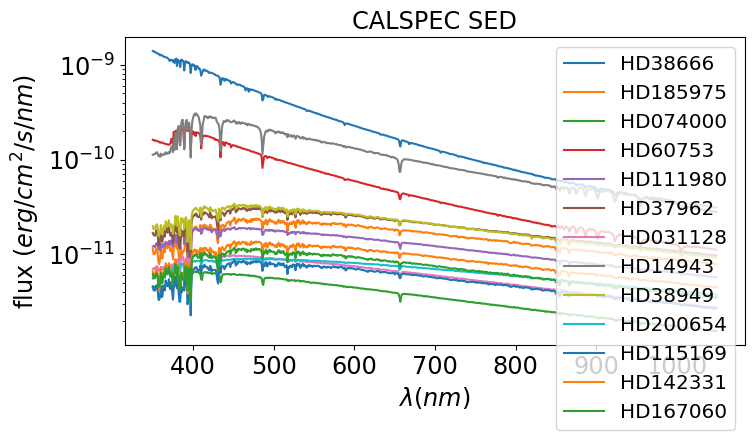

In [47]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WL)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WL,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

# Throughputs

## Auxtel throughput and  telescope throughput

In [48]:
array = np.loadtxt(filename_auxtelthroughput)
dft = pd.DataFrame(data=array,columns=["lambda","throughput"])

In [49]:
#dft = pd.read_excel(filename_auxtelthroughput,header=1,index_col=0)
dft.reset_index(inplace=True)
dft['index'] = dft.reset_index().index
dft.set_index('index')
dft.rename(columns={'lambda':'lambdas'},inplace = True)

Text(0.5, 1.0, 'auxtel throughput')

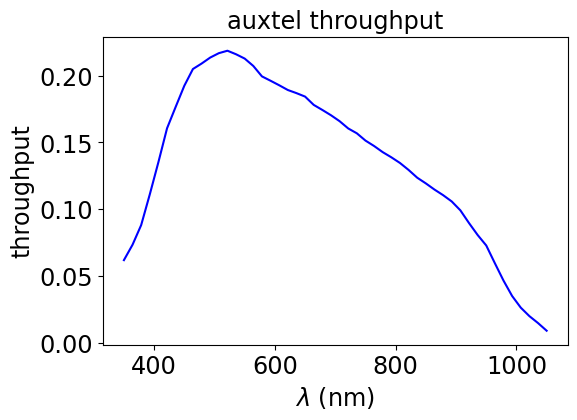

In [50]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(dft.lambdas,dft.throughput,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [51]:
# interpolation function
f_thr = interpolate.interp1d(dft.lambdas,dft.throughput,bounds_error=False,fill_value="extrapolate")

## spectrum data

In [52]:
fullfilename=os.path.join(inputdir,inputfile)

In [53]:
#with open(fullfilename, 'rb') as f:
#    summary_content = pickle.load(f)

In [54]:
hf =  h5py.File(fullfilename, 'r') 
list_of_keys = list(hf.keys())

In [55]:
#NBSPECTRA=len(summary_content)
NBSPECTRA=len(list_of_keys)

In [56]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2023-04-25 13:30:04,268 imacdagoret.lal.in2p3.fr __main__[42624] INFO  Number of selected files is 44


In [57]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [58]:
normalisationfactor

1.0

In [59]:
#infos, all_spectra = GetSpectra(summary_content,factor = normalisationfactor)
infos, all_spectra = GetSpectraH5(hf,factor = normalisationfactor)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
def get_seq(row):
    return row - (row//100000)*100000
infos["number"] = infos[['exposure']].apply(lambda x: get_seq(x))


In [ ]:
N=len(infos)

In [ ]:
NX=4
NY=N/NX

In [ ]:
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

In [ ]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["spec_target_label"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    
    ax.axvline(HBETA.wavelength,linestyle="-",color="k")
    ax.axvline(HALPHA.wavelength,linestyle="-",color="k")
    
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.legend()
    
the_title = f"All spectra {DATE}-{filterdisperser}"

plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_01-{DATE}-{filterdisperser}-allspectra.pdf"
plt.savefig(fig_filename)
plt.show()

# Remove bad Spectra

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.spec_target_label);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target before spectra selection ")

In [ ]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.spec_header_d2ccd,bins=20,range=(170,200));
ax.set_xlabel("spec_header_dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.spec_header_targetx,bins=50,range=(0,500));
ax.set_xlabel("spec_header_targetx")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.spec_header_targety,bins=50,range=(0,2000));
ax.set_xlabel("spec_header_targety")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [ ]:
#selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)
selection_cut = ((infos.spec_header_d2ccd > 178) & (infos.spec_header_d2ccd < 182))
bad_cut = ~selection_cut

In [ ]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

In [ ]:
list_of_badnums2  = np.array([])

#### Remove some targets

In [ ]:
AA = infos["spec_target_label"] == "HD115169"
AB = infos["spec_target_label"] == "HD142331"
AC = infos["spec_target_label"] == "HD146233"
AD = infos["spec_target_label"] == "HD42525"
AE = infos["spec_target_label"] == "HD73495"
AF = infos["spec_target_label"] == "HD167060"
AG = infos["spec_target_label"] == "HD111980"
AH = infos["spec_target_label"] == "HD200654"
AI = infos["spec_target_label"] == "HD60753"
AJ = infos["spec_target_label"] == "HD38949" 	
AK = infos["spec_target_label"] == "HD38666" 
AL = infos["spec_target_label"] == "HD38949"
AM = infos["spec_target_label"] == "HD031128" 	
AN = infos["spec_target_label"] == "HD14943"
AO = infos["spec_target_label"] == "HD074000"
AP = infos["spec_target_label"] == "HD2811" 	
AQ = infos["spec_target_label"] == "HD009051"
AR = infos["spec_target_label"] == "HD205905" 
AS = infos["spec_target_label"] == "HD37962" 	

 	
if FLAG_POLAR:
    selection_cut3 =  AA | AB | AC | AD | AE | AF | AG | AH | AI | AJ | AK | AL | AM | AN | AO | AP | AQ | AR | AS
else:
    selection_cut3 =  AC | AD | AE 
list_of_badnum3 = infos[selection_cut3]["number"].values

In [ ]:
list_of_badnum3

# Union of badnums

In [ ]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums = np.union1d(list_of_badnums,list_of_badnum3)
list_of_badnums=np.unique(list_of_badnums)

# Filtered spectra : remove bad spectra

In [ ]:
list_of_badnums

In [ ]:
hf

In [ ]:
#infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums,factor = normalisationfactor)
infos, all_spectra = GetSpectraH5Filtered(hf,list_of_bad_spectra = list_of_badnums , factor = normalisationfactor)

In [ ]:
infos["number"] = infos[['exposure']].apply(lambda x: get_seq(x))

In [ ]:
print("Number of spectra : ",len(all_spectra))

In [ ]:
infos.reset_index(drop=True, inplace=True)

In [ ]:
infos

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.spec_target_label);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target after spectra selection ")

In [ ]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
numbers = infos['number'].values
airmasses = infos['spec_header_airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)


# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  datetime(2023, 1, 31, 0, 0, 0, 0),

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
#ax.plot(all_datetime,grey_attenuation,'bo:')
#ax.grid()
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_tick_params(rotation=45)
#ax.set_xlabel("time (UTC)")
#ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
#ax.set_ylabel("attenuation")
#ax2 = ax.twinx()

y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
# Plot rectangle
#rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
#ax2.add_patch(rect)   
ax2.invert_yaxis()
ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    
the_title = f"All spectra airmass {DATE}-{filterdisperser}"
plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_02-{DATE}-{filterdisperser}-airmasses.pdf"
plt.savefig(fig_filename)
plt.show()

# Simulate atmospheric transparency

In [ ]:
emul = SimpleAtmEmulator()

In [ ]:
NBINFOS = len(infos)
dict_func_atm = {}
print(NBINFOS)

pwv0 = 3
oz0 = 300.
ncomp=0

for ispec in range(NBINFOS):
    the_infos = infos.iloc[ispec]
    the_airmass = the_infos["spec_header_airmass"]
    the_number = the_infos["number"]
    
    transm = emul.GetAllTransparencies(WL,the_airmass,pwv0,oz0,ncomp=ncomp,flagAerosols=False)
    dict_func_atm[the_number] = interpolate.interp1d(WL,transm,bounds_error=False,fill_value="extrapolate")

In [ ]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBINFOS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBINFOS), alpha=1)

In [ ]:
fig=plt.figure(figsize=(16,16))
ax=fig.add_subplot(111)
for isim in np.arange(NBINFOS):
    
    airmassvalue = infos.iloc[isim]["spec_header_airmass"]
    the_number = infos.iloc[isim]["number"]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    atm = dict_func_atm[the_number](WL)
    
    ax.plot(WL,atm, color=all_colors[isim],label=label_airmass)

ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("air transparency")
title=f"sim. tmospheric transparencies({DATE}) pwv = {pwv0:.2f} mm oz = {oz0:.0f} DU"
ax.set_title(title,fontsize=20,fontweight='bold')

ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(0.,1)
#ax.legend(loc="lower left",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Plot Spectra

In [ ]:
NBSPECTRA=len(all_spectra)

In [ ]:
assert NBSPECTRA == NBINFOS

In [ ]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [ ]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

### load absorption pattern

In [ ]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

In [ ]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

In [ ]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


#gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,4] ,figure=fig)
gs = gridspec.GridSpec(4, 1,height_ratios=[0.5,0.5,0.5,4] ,figure=fig)

#=========================================================== NO2    
#ax=fig.add_subplot(gs[0,0])
#for index in np.arange(NOBS):   
#    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
#ax.set_ylim(0.8,1)
#ax.set_xlim(WLMINSEL,WLMAXSEL)
#ax.grid()
#textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
#ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
#ax.set_title(title,fontsize=20,fontweight='bold')
#main_ax = ax



#=========================================================== O2    
#ax=fig.add_subplot(gs[0,0], sharex=main_ax)
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)
main_ax = ax

#=========================================================== Ozone
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#=========================================================== H2O
ax=fig.add_subplot(gs[2,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#================================================= spectra
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
all_numbers = infos['number'].values



for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["spec_header_airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
#ax.set_ylim(1e-14,1e-10)
#ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=6)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)

plt.tight_layout()


In [ ]:
fig=plt.figure(figsize=(16,16))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["spec_header_airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)

    f_flux = interpolate.interp1d(the_df["all_lambdas"].values,the_df['all_fluxes'].values,bounds_error=False,fill_value=0)
    x1=1000.
    y1=f_flux(x1)
    s1=str(the_number)
    x2=600
    y2=f_flux(x2)
    s2=infos.iloc[ifile]["spec_target_label"]
    ax.text(x1+5, y1, s1, color=all_colors[ifile],fontsize=12)
    ax.text(x2+15, y2*1.1, s2, color=all_colors[ifile],fontsize=14)
    
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
#ax.legend(loc="lower left",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)


In [ ]:
correction_area = 1.06/1.13

In [ ]:
#sed_predicted_f = f_sed(WL) * f_thr(WL) * f_atm(WL) 
#sed_predicted_m = -2.5*np.log10(sed_predicted_f) 

# Fit

## Select the identifier

In [ ]:
dict_ratio = {}
array_ratio = np.zeros((NBSPECTRA,len(WL)))

for idx in range(NBSPECTRA):
    
    fig=plt.figure(figsize=(16,10))
    gs = gridspec.GridSpec(2, 1,height_ratios=[4,1] ,figure=fig)


    # Fig 1
    ax=fig.add_subplot(gs[0,0])

    # extract spectrum from data
    the_df=all_spectra[idx]
    the_number = infos.iloc[idx]["number"]
    airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    target = infos.iloc[idx]["spec_target_label"]
    label_airmass = f" {target}({the_number}) : z = {airmassvalue:.2f}"

    # the SED
    f_sed = dict_f_sed[target] 

    # atmosphere
    the_f_atm = dict_func_atm[the_number]

    # the throughput
    #f_thr

    # prediction
    the_wl = the_df["all_lambdas"].values
    the_sim = f_sed(the_wl) * the_f_atm(the_wl) * f_thr(the_wl)


    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.',color="b",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ax.plot(the_wl,the_sim,'-r')

    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
    title=f"Obs Spectr from {target} at {SITE} ({DATE})"
    ax.set_title(title,fontsize=20,fontweight='bold')
    #ax.plot(sed_w,sed_f,'k-',label="SED")
    #ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
    ax.set_xlim( WLMINSEL  , WLMAXSEL  )

    ax.legend(loc="upper right")
    # draw abs lines
    plotlines(ax,ypos=FLUXLIMMAX/30)
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='purple')
    
    ax.axvline(x=920,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=980,linewidth=2,linestyle=':', color='purple')
    

    main_ax = ax

    # Fig 2
    ax=fig.add_subplot(gs[1,0], sharex=main_ax)

    ax.errorbar(the_wl,the_df['all_fluxes']/correction_area/the_sim,yerr=the_df["all_fluxes_err"], fmt = '.',color="g",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ratio = the_df['all_fluxes']/correction_area/the_sim
    
    # remove absorption line
    xcut1=758
    xcut2=767
    xcut3=925
    xcut4=970
    
    index_to_remove=np.where(np.logical_or(np.logical_and(the_wl>xcut1,the_wl<xcut2),np.logical_and(the_wl>xcut3,the_wl<xcut4)))[0]
    
                             
    new_the_wl = the_wl[~np.isin(np.arange(the_wl.size), index_to_remove)]
    new_ratio = ratio[~np.isin(np.arange(ratio.size), index_to_remove)]
    
    f_ratio = interpolate.interp1d(new_the_wl,new_ratio,bounds_error=False,fill_value="extrapolate")
    ratio_interp =f_ratio(WL)
    
                                
    ax.plot(WL,ratio_interp,'.',color="purple")

    span=30
    ratio_filtered = smooth_data_np_convolve(ratio_interp,span)
    ax.plot(WL,ratio_filtered,'k-',lw=3)
    
    
    dict_ratio[the_number] = ratio_filtered
    array_ratio[idx,:] = ratio_filtered
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='r')
    
    ax.axvline(x=930,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=970,linewidth=2,linestyle=':', color='r')

    ax.grid()
    ax.set_ylim(0,2)
    ax.set_ylabel("ratio data/sim")
    
    plt.show()



### Compute the median ratio

In [ ]:
ratio_median = np.median(array_ratio,axis=0)

In [ ]:
hls_colors = sns.color_palette("hls", NBSPECTRA)

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)

idx=0
for key, value in dict_ratio.items():
    ax.plot(WL,value,"-",color=hls_colors[idx],lw=2)
    idx+=1
    
ax.plot(WL,ratio_median,'k-',lw=3)
ax.set_xlabel("$\lambda$ (nm)")  
ax.set_ylabel("ratio")
ax.set_title("ratio data/sim")
ax.grid()

#### Compute the error ratio_median_error  

In [ ]:
ratio_median_error  = np.std(array_ratio-ratio_median,axis=0) 

In [ ]:
hls_colors = sns.color_palette("hls", NBSPECTRA)

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)

idx=0
for key, value in dict_ratio.items():
    ax.plot(WL,value,"-",color=hls_colors[idx],lw=1,alpha=0.5)
    idx+=1
    
ax.errorbar(WL,ratio_median,yerr=ratio_median_error ,fmt='.',color='k',ecolor="grey",lw=1,alpha=1.0)


ax.set_ylim(0,1)
ax.set_xlabel("$\lambda$ (nm)")  
ax.set_ylabel("ratio")
ax.set_title("ratio data/sim with error bars")

ax.grid()
ax.legend()

### New measured throughput

In [ ]:
hls_colors = sns.color_palette("hls",2)

new_throughput = f_thr(WL)*ratio_median
new_throughput_error = f_thr(WL)*ratio_median_error

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
ax.plot(WL,f_thr(WL),'b-',label = "old Auxtel transmission",lw=2) 
ax.plot(WL,new_throughput,'r-',label = "new Auxtel transmission",lw=2)
ax.errorbar(WL,new_throughput,yerr=new_throughput_error ,fmt='.',color='r',ecolor="grey",lw=1,alpha=1)

ax.plot(WL,2*new_throughput,'g-',label = "new Auxtel transmission x 2",lw=2)
ax.errorbar(WL,2*new_throughput,yerr=new_throughput_error ,fmt='.',color='g',ecolor="grey",lw=1,alpha=1)
ax.legend()
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")  
ax.set_ylabel("throughput")

ax.set_title(f"Auxtel Throughput {DATE} - {filterdisperser} {spectractormode}")
ax.set_ylim(0,.25)

#### Save new throuthput in a file

In [ ]:
df_th_out = pd.DataFrame()
df_th_out["wavelength"] = WL
df_th_out["newthrou"] = new_throughput
df_th_out["newthrouerr"] = new_throughput_error
df_th_out["oldthrou"] = f_thr(WL)

In [ ]:
df_th_out

In [ ]:
filename_newthroughput = f"throughput-{DATE}-{filterdisperser}-{spectractormode}-multifitatmparams.csv"

In [ ]:
df_th_out.to_csv(filename_newthroughput)

## New fittable 

In [ ]:
f_thr_new = interpolate.interp1d(WL,new_throughput,bounds_error=False,fill_value="extrapolate")

In [ ]:
dict_ratio = {}
array_ratio = np.zeros((NBSPECTRA,len(WL)))

for idx in range(NBSPECTRA):
    
    fig=plt.figure(figsize=(16,10))
    gs = gridspec.GridSpec(2, 1,height_ratios=[4,1] ,figure=fig)


    # Fig 1
    ax=fig.add_subplot(gs[0,0])

    # extract spectrum from data
    the_df=all_spectra[idx]
    the_number = infos.iloc[idx]["number"]
    airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    target = infos.iloc[idx]["spec_target_label"]
    label_airmass = f" {target}({the_number}) : z = {airmassvalue:.2f}"

    # the SED
    f_sed = dict_f_sed[target] 

    # atmosphere
    the_f_atm = dict_func_atm[the_number]

    # the throughput
    #f_thr

    # prediction
    the_wl = the_df["all_lambdas"].values
    the_sim = f_sed(the_wl) * the_f_atm(the_wl) * f_thr_new(the_wl)


    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.',color="b",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ax.plot(the_wl,the_sim,'r-',lw=2)

    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
    title=f"Obs Spectr from {target} at {SITE} ({DATE})"
    ax.set_title(title,fontsize=20,fontweight='bold')
    #ax.plot(sed_w,sed_f,'k-',label="SED")
    #ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
    ax.set_xlim( WLMINSEL  , WLMAXSEL  )

    ax.legend(loc="upper right")
    # draw abs lines
    plotlines(ax,ypos=FLUXLIMMAX/30)
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='purple')
    
    ax.axvline(x=920,linewidth=2,linestyle=":" ,color='purple')
    ax.axvline(x=980,linewidth=2,linestyle=':', color='purple')
    

    main_ax = ax

    # Fig 2
    ax=fig.add_subplot(gs[1,0], sharex=main_ax)

    ax.errorbar(the_wl,the_df['all_fluxes']/correction_area/the_sim,yerr=the_df["all_fluxes_err"], fmt = '.',color="g",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ratio = the_df['all_fluxes']/correction_area/the_sim
    
    # remove absorption line
    xcut1=758
    xcut2=767
    xcut3=925
    xcut4=970
    
    index_to_remove=np.where(np.logical_or(np.logical_and(the_wl>xcut1,the_wl<xcut2),np.logical_and(the_wl>xcut3,the_wl<xcut4)))[0]
    
                             
    new_the_wl = the_wl[~np.isin(np.arange(the_wl.size), index_to_remove)]
    new_ratio = ratio[~np.isin(np.arange(ratio.size), index_to_remove)]
    
    f_ratio = interpolate.interp1d(new_the_wl,new_ratio,bounds_error=False,fill_value="extrapolate")
    ratio_interp =f_ratio(WL)
    
                                
    ax.plot(WL,ratio_interp,'.',color="purple")

    span=30
    ratio_filtered = smooth_data_np_convolve(ratio_interp,span)
    ax.plot(WL,ratio_filtered,'k-',lw=3)
    
    
    dict_ratio[the_number] = ratio_filtered
    array_ratio[idx,:] = ratio_filtered
    
    ax.axvline(x=758,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=767,linewidth=2,linestyle=':', color='r')
    
    ax.axvline(x=930,linewidth=2,linestyle=":" ,color='r')
    ax.axvline(x=970,linewidth=2,linestyle=':', color='r')

    ax.grid()
    ax.set_ylim(0,2)
    ax.set_ylabel("ratio data/sim")
    
    plt.show()



# Do the fit

https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Extract data for the fit

In [ ]:
idx = 0
the_df=all_spectra[idx]
data = the_df['all_fluxes']/correction_area
dataerr = the_df["all_fluxes_err"]/correction_area
data_the_wl = the_df["all_lambdas"].values

index_sel= np.where(np.logical_and(data_the_wl>WLMINSEL,data_the_wl<WLMAXSEL))[0]

data = data[index_sel].values
dataerr = dataerr[index_sel].values 
data_the_wl = data_the_wl[index_sel]
                    
data_airmassvalue = infos.iloc[idx]["spec_header_airmass"]
data_target = infos.iloc[idx]["spec_target_label"]
f_sed = dict_f_sed[data_target] 
data_the_sedxthroughput = f_sed(data_the_wl) * f_thr_new(data_the_wl)

### Extract the covariance matrix

In [ ]:
the_exposure = infos.iloc[idx]['exposure']
group = hf.get(str(the_exposure))
cov = np.array(group.get("spec_covmatrix"))/correction_area**2

In [ ]:
data_cov = cov[:,index_sel]
data_cov = data_cov[index_sel,:]

### Set global variables required in the Fit function

In [ ]:
#need those two gloabal vriables
global g_airmass
g_airmass = data_airmassvalue
global g_sedxthrouput
g_sedxthrouput = data_the_sedxthroughput

In [ ]:
data_airmassvalue

### Initialisation of the parameter fit

In [ ]:
pwv0 = 3.0
oz0 = 300.
params0 = np.array([1,pwv0,oz0],dtype=object)

### MyFitter

In [ ]:
myFitter = FitAtmosphericParamsCov()

In [ ]:
#self,params0,xdata,ydata,covdata,airmass,sedxthroughput
popt,pcov,res,myfit=myFitter.fit_greypwvo3(params0,data_the_wl,data,data_cov,data_airmassvalue,data_the_sedxthroughput)

In [ ]:
popt

In [ ]:
myfit

In [ ]:
the_model = myFitter.pred_greypwvo3(myfit["popt"],data_the_wl,data_airmassvalue,data_the_sedxthroughput)

In [ ]:
func_model_greypwvo3(data_the_wl,*popt)

## Loop on fits

In [ ]:
# extract spectrum from data
dict_fit1 = OrderedDict()  # full range wavelength fit
dict_fit2 = OrderedDict()  # Fit PWV : 850-1000 nm
dict_fit3 = OrderedDict()  # Fit PWV : 800-850 nm
dict_fit4 = OrderedDict()  # Fit PWV : 700-750 nm



# H2O(900) band selection
wlh2omin2 = 850
wlh2omax2 = 1000
dwlh2o2 = wlh2omax2-wlh2omin2

# H2O(800) band selection
wlh2omin3 = 780
wlh2omax3 = 855
dwlh2o3 = wlh2omax3-wlh2omin3

# H2O(700) band selection
wlh2omin4 = 695
wlh2omax4 = 755
dwlh2o4 = wlh2omax3-wlh2omin4



# fit 1 : initial values for the parameters
pwv0 = 4.0
oz0 = 300.
params0 = np.array([1,pwv0,oz0],dtype=object)

# fit 2 : initial values for the parameters
pwv0 = 4.0
params1 = np.array([1,pwv0],dtype=object)


# loop on all spectra
for idx in range(NBSPECTRA):
    
    ####################################################################
    ## Two Figures 
    #####################################################################
    fig=plt.figure(figsize=(16,14))
    gs = gridspec.GridSpec(2, 1,height_ratios=[4,1] ,figure=fig)

    ####################################################################
    ## Figure 1
    #####################################################################
    ax=fig.add_subplot(gs[0,0])
    
    
    the_df=all_spectra[idx]
    data = the_df['all_fluxes']/correction_area
    dataerr = the_df["all_fluxes_err"]/correction_area
    data_the_wl = the_df["all_lambdas"].values

    index_sel= np.where(np.logical_and(data_the_wl>WLMINSEL,data_the_wl<WLMAXSEL))[0]

    data = data[index_sel].values
    dataerr = dataerr[index_sel].values 
    data_the_wl = data_the_wl[index_sel]
                    
    data_airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    data_target = infos.iloc[idx]["spec_target_label"]
    data_number = infos.iloc[idx]["number"]
    
    f_sed = dict_f_sed[data_target] 
    data_the_sedxthroughput = f_sed(data_the_wl) * f_thr_new(data_the_wl)

    label_airmass = f" {data_target}({data_number}) : z = {data_airmassvalue:.2f}"
    
    
    
     # SET GLOBAL VARIABLES
    g_airmass = data_airmassvalue
    g_sedxthrouput = data_the_sedxthroughput
    
    
    #GET COVARIANCE
    the_exposure = infos.iloc[idx]['exposure']
    group = hf.get(str(the_exposure))
    cov = np.array(group.get("spec_covmatrix"))/correction_area**2
    
    data_cov = cov[:,index_sel]
    data_cov = data_cov[index_sel,:]
    
    
    
    
    
    print(f"======================================= {idx} :{label_airmass} =================================")
    
    
    ## 1st Fit on the whole range : Compute the fit of the parameters (alpha,pwv,oz)
    ## -----------------------------------------------------------------------------
    
    popt,pcov,res,myfit=myFitter.fit_greypwvo3(params0,data_the_wl,data,data_cov,data_airmassvalue,data_the_sedxthroughput)
    
    alpha_fit,pwv_fit,oz_fit = myfit["popt"]
    greye,pwve,oze = myfit["sigmas"]
    
    chi2 = myfit["chi2"]
    chi2_per_deg = myfit["chi2_per_deg"]
    
    # sub dict
    dict_infofit1 = {}
    dict_infofit1["params"] = myfit["popt"]
    dict_infofit1["eparams"] = myfit["sigmas"]
    dict_infofit1["chi2perdeg"] = myfit["chi2_per_deg"]
    
   
    
    label_fit1 =f"fit(350-1000nm) (chi2/Ndeg = {chi2_per_deg:.0f} ): pwv = {pwv_fit:.2f} +/- {pwve:.2f} mm, ozone = {oz_fit:.1f} +/- {oze:.1f} , grey-fact = {alpha_fit:.2f} +/- {greye:.2f}" 
    # Compute the prediction
    the_model1 = myFitter.pred_greypwvo3(myfit["popt"],data_the_wl,data_airmassvalue,data_the_sedxthroughput)
   

    ## 2nd Fit on PWV in H2O(900) Compute the fit of the parameters (alpha,pwv)
    ## ------------------------------------------------------------------------
    
    indexes_lwselection2 = np.where(np.logical_and(data_the_wl > wlh2omin2 , data_the_wl < wlh2omax2))[0]
    data_the_wl2 = data_the_wl[indexes_lwselection2]
    data2 = data[indexes_lwselection2]
    dataerr2 = dataerr[indexes_lwselection2]
    data_the_sedxthroughput2 = data_the_sedxthroughput[indexes_lwselection2]
    
    
    # SET GLOBAL VARIABLES
    g_airmass = data_airmassvalue
    g_sedxthrouput = data_the_sedxthroughput2
    
    #GET COVARIANCE
    the_exposure = infos.iloc[idx]['exposure']
    group = hf.get(str(the_exposure))
    cov2 = np.array(group.get("spec_covmatrix"))/correction_area**2
    
    data_cov2 = cov2[:,indexes_lwselection2]
    data_cov2 = data_cov2[indexes_lwselection2,:]
    
    
    
    popt2,pcov2,res2,myfit2=myFitter.fit_greypwv(params1,data_the_wl2,data2,data_cov2,data_airmassvalue,data_the_sedxthroughput2)
    #myres2,myfit2=myFitter.fit_greypwv(params1,data_the_wl2,data2,dataerr2,data_airmassvalue,data_the_sedxthroughput2)
    
    alpha_fit2,pwv_fit2 = myfit2["popt"]
    greye2,pwve2= myfit2["sigmas"]
    
    chi22 = myfit2["chi2"]
    chi22_per_deg = myfit2["chi2_per_deg"]
    
    
    # sub dict
    dict_infofit2 = {}
    dict_infofit2["params"] = myfit2["popt"]
    dict_infofit2["eparams"] = myfit2["sigmas"]
    dict_infofit2["chi2perdeg"] = myfit2["chi2_per_deg"]
     
    label_fit2 =f"fit(850-1000nm) (chi2/Ndeg = {chi22_per_deg:.0f} ): pwv = {pwv_fit2:.2f} +/- {pwve2:.2f} mm, grey-fact = {alpha_fit2:.2f} +/- {greye2:.2f}" 
    # Compute the prediction
    the_model2 = myFitter.pred_greypwv(myfit2["popt"],data_the_wl2,data_airmassvalue,data_the_sedxthroughput2)

    
    
    ## 3rd Fit on PWV in H2O(800) Compute the fit of the parameters (alpha,pwv)
    ## ------------------------------------------------------------------------
    
    
    indexes_lwselection3 = np.where(np.logical_and(data_the_wl > wlh2omin3 , data_the_wl < wlh2omax3))[0]
    data_the_wl3 = data_the_wl[indexes_lwselection3]
    data3 = data[indexes_lwselection3]
    dataerr3 = dataerr[indexes_lwselection3]
    data_the_sedxthroughput3 = data_the_sedxthroughput[indexes_lwselection3]
    
    # SET GLOBAL VARIABLES
    g_airmass = data_airmassvalue
    g_sedxthrouput = data_the_sedxthroughput3
    
    #GET COVARIANCE
    the_exposure = infos.iloc[idx]['exposure']
    group = hf.get(str(the_exposure))
    cov3 = np.array(group.get("spec_covmatrix"))/correction_area**2
    
    data_cov3 = cov3[:,indexes_lwselection3]
    data_cov3 = data_cov3[indexes_lwselection3,:]
    
    
    popt3,pcov3,res3,myfit3 = myFitter.fit_greypwv(params1,data_the_wl3,data3,data_cov3,data_airmassvalue,data_the_sedxthroughput3)  
    #myres3,myfit3=myFitter.fit_greypwv(params1,data_the_wl3,data3,dataerr3,data_airmassvalue,data_the_sedxthroughput3)
      
    alpha_fit3,pwv_fit3 = myfit3["popt"]
    greye3,pwve3 = myfit3["sigmas"]
    
    chi23 = myfit3["chi2"]
    chi23_per_deg = myfit3["chi2_per_deg"]
    
    # sub dict
    dict_infofit3 = {}
    dict_infofit3["params"] = myfit3["popt"]
    dict_infofit3["eparams"] = myfit3["sigmas"]
    dict_infofit3["chi2perdeg"] = myfit3["chi2_per_deg"]
     
    label_fit3 =f"fit(800-850nm) (chi2/Ndeg = {chi23_per_deg:.0f} ): pwv = {pwv_fit3:.2f} +/- {pwve3:.2f} mm, grey-fact = {alpha_fit3:.2f} +/- {greye3:.2f}" 
    # Compute the prediction
    the_model3 = myFitter.pred_greypwv(myfit3["popt"],data_the_wl3,data_airmassvalue,data_the_sedxthroughput3)

    
    ## 4th Fit on PWV in H2O(700) Compute the fit of the parameters (alpha,pwv)
    ## ------------------------------------------------------------------------
    
    indexes_lwselection4 = np.where(np.logical_and(data_the_wl > wlh2omin4 , data_the_wl < wlh2omax4))[0]
    data_the_wl4 = data_the_wl[indexes_lwselection4]
    data4 = data[indexes_lwselection4]
    dataerr4 = dataerr[indexes_lwselection4]
    data_the_sedxthroughput4 = data_the_sedxthroughput[indexes_lwselection4]
    
    
     # SET GLOBAL VARIABLES
    g_airmass = data_airmassvalue
    g_sedxthrouput = data_the_sedxthroughput4
    
    #GET COVARIANCE
    the_exposure = infos.iloc[idx]['exposure']
    group = hf.get(str(the_exposure))
    cov4 = np.array(group.get("spec_covmatrix"))/correction_area**2
    
    data_cov4 = cov4[:,indexes_lwselection4]
    data_cov4 = data_cov4[indexes_lwselection4,:]
    
    
    popt4,pcov4,res4,myfit4 = myFitter.fit_greypwv(params1,data_the_wl4,data4,data_cov4,data_airmassvalue,data_the_sedxthroughput4)    
    #myres4,myfit4=myFitter.fit_greypwv(params1,data_the_wl4,data4,dataerr4,data_airmassvalue,data_the_sedxthroughput4)
      
    alpha_fit4,pwv_fit4 = myfit4["popt"]
    greye4,pwve4 = myfit4["sigmas"]
    
    chi24 = myfit4["chi2"]
    chi24_per_deg = myfit4["chi2_per_deg"]
    
    # sub dict
    dict_infofit4 = {}
    dict_infofit4["params"] = myfit4["popt"]
    dict_infofit4["eparams"] = myfit4["sigmas"]
    dict_infofit4["chi2perdeg"] = myfit4["chi2_per_deg"]
     
    label_fit4 =f"fit(700-750nm) (chi2/Ndeg = {chi24_per_deg:.0f} ): pwv = {pwv_fit4:.2f} +/- {pwve4:.2f} mm, grey-fact = {alpha_fit4:.2f} +/- {greye4:.2f}" 
    # Compute the prediction
    the_model4 = myFitter.pred_greypwv(myfit4["popt"],data_the_wl4,data_airmassvalue,data_the_sedxthroughput4)
    
    
    ######
    # plot
    ######

    ax.errorbar(data_the_wl,data,yerr=dataerr, fmt = '.',ms=5,color="b",capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
    ax.plot(data_the_wl,the_model1,'r-',label=label_fit1,lw=3)
    ax.plot(data_the_wl2,the_model2,'g-',label=label_fit2,lw=5)
    ax.plot(data_the_wl3,the_model3,'-',color="orange",label=label_fit3,lw=5)
    ax.plot(data_the_wl4,the_model4,'-',color="cyan",label=label_fit4,lw=5)

    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
    title=f"Fit Obs Spectr from {data_target} at {SITE} ({DATE}) {spectractormode}"
    ax.set_title(title,fontsize=20,fontweight='bold')
    #ax.plot(sed_w,sed_f,'k-',label="SED")
    #ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
    ax.set_xlim( WLMINSEL  , WLMAXSEL  )
    ymax_toplot = data.max()*1.4
    ax.set_ylim(0,ymax_toplot)

    ax.legend(loc="upper left")
    # draw abs lines
    plotlines(ax,ypos=ymax_toplot/10.)
    
    #ax.axvline(x=758,linewidth=2,linestyle=":" ,color='purple')
    #ax.axvline(x=767,linewidth=2,linestyle=':', color='purple')
    
    #ax.axvline(x=920,linewidth=2,linestyle=":" ,color='purple')
    #ax.axvline(x=980,linewidth=2,linestyle=':', color='purple')
    main_ax = ax
    ###############################################################
    # Figure 2 deviation of data/sim from a straight line
    ################################################################
    
    ax=fig.add_subplot(gs[1,0], sharex=main_ax)

    ### 
    flux_from_data_fullscale = data
    flux_from_data_err_fullscale = dataerr
    wl_fullscale = data_the_wl
    ratio_fullscale = flux_from_data_fullscale/the_model1
    ratio_err_fullscale = flux_from_data_err_fullscale/the_model1
    
    ###
    flux_from_data_smallscale2 = data2
    flux_from_data_err_smallscale2 = dataerr2
    wl_smallscale2 = data_the_wl2 
    ratio_smallscale2 = flux_from_data_smallscale2/the_model2
    ratio_err_smallscale2 = flux_from_data_err_smallscale2/the_model2
    ##
    flux_from_data_smallscale3 = data3
    flux_from_data_err_smallscale3 = dataerr3
    wl_smallscale3 = data_the_wl3 
    ratio_smallscale3 = flux_from_data_smallscale3/the_model3
    ratio_err_smallscale3 = flux_from_data_err_smallscale3/the_model3
    ##
    flux_from_data_smallscale4 = data4
    flux_from_data_err_smallscale4 = dataerr4
    wl_smallscale4 = data_the_wl4 
    ratio_smallscale4 = flux_from_data_smallscale4/the_model4
    ratio_err_smallscale4 = flux_from_data_err_smallscale4/the_model4
    
    
    
    
    I1 = np.trapz((ratio_fullscale [indexes_lwselection2]-1),wl_fullscale[indexes_lwselection2])/dwlh2o2
    I1err2 = np.trapz(ratio_err_fullscale[indexes_lwselection2]**2,wl_fullscale[indexes_lwselection2])/dwlh2o2
    I1err = np.sqrt(I1err2)
    SNR1 = np.abs(I1/I1err)
    label_I1 = f"I1 = {I1:.4f} +/- {I1err:.4f} (SNR1 = {SNR1:.2f})"
    
    I2 = np.trapz((ratio_smallscale2-1),wl_smallscale2)/dwlh2o2
    I2err2 = np.trapz(ratio_err_smallscale2**2,wl_smallscale2)/dwlh2o2
    I2err = np.sqrt(I2err2)
    SNR2 = np.abs(I2/I2err)
    label_I2 = f"I2 = {I2:.4f} +/- {I2err:.4f} (SNR2 = {SNR2:.2f})"
    
    I3 = np.trapz((ratio_smallscale3-1),wl_smallscale3)/dwlh2o3
    I3err2 = np.trapz(ratio_err_smallscale3**2,wl_smallscale3)/dwlh2o3
    I3err = np.sqrt(I3err2)
    SNR3 = np.abs(I3/I3err)
    label_I3 = f"I3 = {I3:.4f} +/- {I3err:.4f} (SNR3 = {SNR3:.2f})"
    
    
    I3 = np.trapz((ratio_smallscale3-1),wl_smallscale3)/dwlh2o3
    I3err2 = np.trapz(ratio_err_smallscale3**2,wl_smallscale3)/dwlh2o3
    I3err = np.sqrt(I3err2)
    SNR3 = np.abs(I3/I3err)
    label_I3 = f"I3 = {I3:.4f} +/- {I3err:.4f} (SNR3 = {SNR3:.2f})"
    
    I4 = np.trapz((ratio_smallscale4-1),wl_smallscale4)/dwlh2o4
    I4err2 = np.trapz(ratio_err_smallscale4**2,wl_smallscale4)/dwlh2o4
    I4err = np.sqrt(I4err2)
    SNR4 = np.abs(I4/I4err)
    label_I4 = f"I4 = {I4:.4f} +/- {I4err:.4f} (SNR4 = {SNR4:.2f})"
    
    ax.errorbar(wl_fullscale,ratio_fullscale,yerr=ratio_err_fullscale,fmt = '.',ms=5,color="r",capsize = 0.1, ecolor="r", elinewidth = .3,label=label_I1)
    ax.errorbar(wl_smallscale2,ratio_smallscale2,yerr=ratio_err_smallscale2,fmt = '.',ms=5,color="g",capsize = 0.5, ecolor="g", elinewidth = .3,label=label_I2)
    ax.errorbar(wl_smallscale3,ratio_smallscale3,yerr=ratio_err_smallscale3,fmt = '.',ms=5,color="orange",capsize = 0.5, ecolor="orange", elinewidth = .3,label=label_I3)
    ax.errorbar(wl_smallscale4,ratio_smallscale4,yerr=ratio_err_smallscale4,fmt = '.',ms=5,color="cyan",capsize = 0.5, ecolor="cyan", elinewidth = .3,label=label_I4)

    
    ax.set_ylim(0.8,1.2)
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("ratio data/sim")
    ax.grid()
    ax.legend(loc="upper left")
    
    # save in a dictionnaries
    dict_infofit1["SNR"] = SNR1
    dict_infofit2["SNR"] = SNR2
    dict_infofit3["SNR"] = SNR3
    dict_infofit4["SNR"] = SNR4
    
    # main dict for fit 1
    dict_fit1[data_number] = dict_infofit1
    
    # main dict for fit 2
    dict_fit2[data_number] = dict_infofit2
    
    # main dict for fit 3
    dict_fit3[data_number] = dict_infofit3
    
    # main dict for fit 4
    dict_fit4[data_number] = dict_infofit4
    
    
    plt.show()
    


# Save Fits results in infos

#### Fit 1

In [ ]:
df_fitatm1 = pd.DataFrame(columns=['number1', 'chi2_1','pwv_1', 'oz_1','grey_1','epwv_1' ,'eoz_1', 'egrey_1','SNR_1'])

count = 0
for key, value in dict_fit1.items():
    df_fitatm1.loc[count] = [key, value["chi2perdeg"], value["params"][1],value["params"][2],value["params"][0],value["eparams"][1],value["eparams"][2],value["eparams"][0],value["SNR"] ]
    count+=1

df_fitatm1['number1'] = df_fitatm1['number1'].astype('int32')    

In [ ]:
df_fitatm1.head()

#### Fit 2

In [ ]:
df_fitatm2 = pd.DataFrame(columns=['number2', 'chi2_2','pwv_2','grey_2','epwv_2' , 'egrey_2','SNR_2'])

count = 0
for key, value in dict_fit1.items():
    df_fitatm2.loc[count] = [key, value["chi2perdeg"], value["params"][1],value["params"][0],value["eparams"][1],value["eparams"][0],value["SNR"] ]
    count+=1

df_fitatm2['number2'] = df_fitatm2['number2'].astype('int32')   

In [ ]:
df_fitatm2.head()

#### Fit 3

In [ ]:
df_fitatm3 = pd.DataFrame(columns=['number3', 'chi2_3','pwv_3','grey_3','epwv_3' , 'egrey_3','SNR_3'])

count = 0
for key, value in dict_fit3.items():
    df_fitatm3.loc[count] = [key, value["chi2perdeg"], value["params"][1],value["params"][0],value["eparams"][1],value["eparams"][0],value["SNR"] ]
    count+=1

df_fitatm3['number3'] = df_fitatm3['number3'].astype('int32')   

In [ ]:
df_fitatm3.head()

#### Fit 4

In [ ]:
df_fitatm4 = pd.DataFrame(columns=['number4', 'chi2_4','pwv_4','grey_4','epwv_4','egrey_4','SNR_4'])

count = 0
for key, value in dict_fit4.items():
    df_fitatm4.loc[count] = [key, value["chi2perdeg"], value["params"][1],value["params"][0],value["eparams"][1],value["eparams"][0],value["SNR"] ]
    count+=1

df_fitatm4['number4'] = df_fitatm4['number4'].astype('int32')   

In [ ]:
df_fitatm4.head()

### Combine infos and fits results

In [ ]:
df_combined = pd.concat([infos,df_fitatm1, df_fitatm2,df_fitatm3, df_fitatm4],axis=1)

In [ ]:
df_combined.head()

In [ ]:
df_combined.drop(columns=['number1', 'number2','number3','number4'],inplace=True)

In [ ]:
df_combined.head()

In [ ]:
df_combined['pwv_avg'] = df_combined.apply(lambda x: (x.pwv_1/x.epwv_1**2+
                                                      x.pwv_2/x.epwv_2**2+
                                                      x.pwv_3/x.epwv_3**2+
                                                      x.pwv_4/x.epwv_4**2)/(
                                                      1/x.epwv_1**2+ 1/x.epwv_2**2 + 1/x.epwv_3**2 + 1/x.epwv_4**2)
                                           , axis=1)

In [ ]:
#df_combined['pwv_sig'] = df_combined.apply(lambda x: np.sqrt(( (x.pwv_1-x.pwv_avg)**2/x.epwv_1**2+
#                                                       (x.pwv_2-x.pwv_avg)**2/x.epwv_2**2+
#                                                       (x.pwv_3-x.pwv_avg)**2/x.epwv_3**2+
#                                                       (x.pwv_4-x.pwv_avg)**2/x.epwv_4**2)/(
#                                                      1/x.epwv_1**2+ 1/x.epwv_2**2 + 1/x.epwv_3**2 + 1/x.epwv_4**2))
#                                           , axis=1)

In [ ]:
df_combined['pwv_sig'] = df_combined.apply(lambda x: np.sqrt(( (x.pwv_1-x.pwv_avg)**2+
                                                       (x.pwv_2-x.pwv_avg)**2+
                                                       (x.pwv_3-x.pwv_avg)**2+
                                                       (x.pwv_4-x.pwv_avg)**2)/(4)), axis=1)

In [ ]:
df_combined['pwv_sig']

In [ ]:
if FLAG_POLAR: 
    filename_fit = f"multifitcovparamatm-{DATE}-{filterdisperser}-{spectractormode}-polar.csv"
else:
    filename_fit = f"multifitcovparamatm-{DATE}-{filterdisperser}-{spectractormode}.csv"

In [ ]:
df_combined.to_csv(filename_fit)

## Plot

In [ ]:
df=df_combined.dropna(axis=0)
df =df[df["pwv_sig"]<1]

In [ ]:
df.columns

In [ ]:
all_datetime = [ Time(str_time).to_datetime() for str_time in df['spec_date_obs'] ]
numbers = df['number'].values
    
pwv= df['pwv_avg'].values
epwv= df['pwv_sig'].values
     
N= len(numbers)
   

# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  all_datetime[-1]

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 2,width_ratios=[3,1],figure=fig)
    
ax= fig.add_subplot(gs[0,0])
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
 

y_shift= 1

  
ax.plot(all_datetime,pwv,'r:o',color="r",lw=3)
ax.errorbar(all_datetime,pwv,yerr=epwv,fmt='o',color="r",ecolor="k",lw=1,alpha=1)
    
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("time (UTC)")
ax.set_ylabel("pwv (mm)")
ax.set_ylim(pwv.min()-2*y_shift,pwv.max()+2*y_shift)
    # Plot rectangle
    #rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
    #ax2.add_patch(rect)   
    #ax.invert_yaxis()
ax.grid()
ax.set_ylim(0.,10.)


for index in range(N):
    textstr= str(numbers[index])
        
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax.text(all_datetime[index], pwv[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    
    
    
ax= fig.add_subplot(gs[0,1])
ax.hist(pwv,bins=25,range=(0,10))
ax.set_xlabel("pwv (mm)")
    
mu = pwv.mean()
median = np.median(pwv)
sigma =pwv.std()
    
textstr = '\n'.join((
r'$\mu=%.2f$ mm' % (mu, ),
r'$\mathrm{median}=%.2f$ mm' % (median, ),
r'$\sigma=%.2f$ mm' % (sigma, )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

    
the_title=f"PWV Obs Spectr at {SITE} ({DATE}) {spectractormode}"   

plt.suptitle(the_title,fontsize="20",fontweight="bold")
plt.show()
    